<a href="https://colab.research.google.com/github/componavt/volcano_wikidata/blob/main/src/bipartite_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧠 Bipartite Clustering of Volcanoes and Earthquakes 🌋🌍

This notebook implements a custom bipartite clustering algorithm to study spatial relationships between volcanoes and earthquakes.
It treats volcanoes and earthquakes as two different sets of nodes and forms clusters based only on volcano–earthquake proximity, not between volcanoes or between earthquakes.
Key Features:
   
    📈 Dynamically tracks cluster structure using union–find (disjoint-set).

    🌀 At each clustering step (by increasing distance), it records:

        Total number of clusters

        Size of the largest cluster

        Average cluster size

        Diameter (max distance) within the largest cluster

        Number of clusters of 3 types:

            Only volcanoes

            Only earthquakes

            Mixed volcano–earthquake clusters

Output:

    📊 Two graphs show cluster evolution:

        Main metrics (group count, size, diameter)

        Composition breakdown (volcano-only, earthquake-only, mixed)

    🖨️ Console progress with % completion and current distance.

🔍 Двудольная кластеризация вулканов и землетрясений 🌋📊

Этот код реализует специальный алгоритм кластеризации, который объединяет вулканы и землетрясения в группы, учитывая только пары между вулканом и землетрясением.
Особенности:

    📐 Использует геодезическое расстояние между координатами (из Wikidata).

    🚫 Игнорирует пары, расстояние между которыми превышает MAX_DISTANCE_KM.

    🔢 Для каждого землетрясения учитываются только K ближайших вулканов (K_NEAREST).

    🔁 Кластеры формируются с помощью структуры непересекающихся множеств (union–find).

    📊 На каждом шаге кластеризации (по возрастанию расстояния) сохраняется:

        Общее количество кластеров

        Размер наибольшего кластера

        Средний размер кластеров

        Диаметр наибольшего кластера

        Количество кластеров следующих типов:

            Только вулканы

            Только землетрясения

            Смешанные (вулканы + землетрясения)

Результаты:

    📈 Построены два графика:

        Эволюция метрик кластеров

        Состав кластеров по типу

    ⏳ В консоли отображается ход выполнения и текущая итерация.

In [1]:
# Input parameters
LANGUAGE = 'ru'  # 'en' or 'ru'

f_volcano = "volcanoes_2023.csv"
f_earthquake = "earthquakes_2023.csv"

# --- Distance thresholds to explore ---
# dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

# distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
# distances_max_list = range(30, 150, 10)
distances_max_list = list(range(30, 80, 10)) + list(range(80, 100, 1)) + list(range(100, 150, 10)) # slow real
# distances_max_list = list(range(30, 80, 20)) + list(range(80, 100, 5)) + list(range(100, 150, 20)) # fast

# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]
#distances_max_list = list(range(80, 120, 10)) + list(range(120, 130, 1)) + list(range(130, 170, 10))

# fast: шаг 40 для диапазона 80-170, но шаг 5 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 120, 127, 128, 130, 170]
#distances_max_list = list(range(80, 121, 40)) + [125] + list(range(127, 129, 1)) + list(range(130, 171, 40))
#distances_max_list = list(range(80, 121, 40))          + list(range(127, 129, 1)) + list(range(130, 171, 40))

print(distances_max_list)

[30, 40, 50, 60, 70, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 110, 120, 130, 140]


In [2]:
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import folium
# import pprint # Pretty Print for objects


# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_earthquake

!head -n 3 $f_volcano
!head -n 3 $f_earthquake

--2025-05-02 05:39:18--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/volcanoes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76165 (74K) [text/plain]
Saving to: ‘volcanoes_2023.csv’

volcanoes_2023.csv  100%[===================>]  74.38K  --.-KB/s    in 0.008s  

2025-05-02 05:39:18 (8.76 MB/s) - ‘volcanoes_2023.csv’ saved [76165/76165]

--2025-05-02 05:39:18--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/earthquakes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

# 📏 Computing the Maximum Diameter of a Group

In [3]:
from geopy.distance import geodesic

def compute_group_diameter(group_coords):
    max_distance = 0
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
    return max_distance

# 📉 Compresses scale before 120, 📈 stretches 120-130, 📉 compresses after 130.

In [4]:
def transform_x(x, compress_before=0.5, compress_between=2.0, compress_after=0.5):
    """
    Transforms the input distance x with different compression ratios for different intervals.

    Parameters:
        x (float): Input distance value to be transformed
        compress_before (float): Compression factor for x < 120 (default: 0.5)
        compress_between (float): Compression/stretch factor for 120 <= x <= 130 (default: 2.0)
        compress_after (float): Compression factor for x > 130 (default: 0.5)

    Returns:
        float: Transformed value of x according to the specified compression rules

    Behavior:
        - For x < 120: applies compress_before multiplier (compression if < 1.0)
        - For 120-130: applies compress_between multiplier (stretches if > 1.0)
        - For x > 130: applies compress_after multiplier (compression if < 1.0)
    """
    if x < 120:
        return x * compress_before  # Compress region before 120 km
    elif 120 <= x <= 130:
        return 120 * compress_before + (x - 120) * compress_between  # Transform 120-130 km region
    else:
        return (120 * compress_before + 10 * compress_between) + (x - 130) * compress_after  # Compress region after 130 km

[    0/2191] —   0.0% complete — dist =   1.16 km, clusters = 3653, diameter = 0.00
[  100/2191] —   4.6% complete — dist =  17.53 km, clusters = 3556, diameter = 0.02
[  300/2191] —  13.7% complete — dist =  38.26 km, clusters = 3377, diameter = 0.08
[  400/2191] —  18.3% complete — dist =  50.74 km, clusters = 3298, diameter = 0.18
[  500/2191] —  22.8% complete — dist =  58.35 km, clusters = 3225, diameter = 0.10
[  600/2191] —  27.4% complete — dist =  68.81 km, clusters = 3161, diameter = 0.11
[  700/2191] —  31.9% complete — dist =  76.67 km, clusters = 3086, diameter = 0.47
[  900/2191] —  41.1% complete — dist =  90.61 km, clusters = 2966, diameter = 0.16
[ 1000/2191] —  45.6% complete — dist =  99.17 km, clusters = 2893, diameter = 0.54
[ 1300/2191] —  59.3% complete — dist = 120.28 km, clusters = 2719, diameter = 0.42
[ 1600/2191] —  73.0% complete — dist = 147.89 km, clusters = 2556, diameter = 0.42
[ 1700/2191] —  77.6% complete — dist = 154.35 km, clusters = 2496, diameter

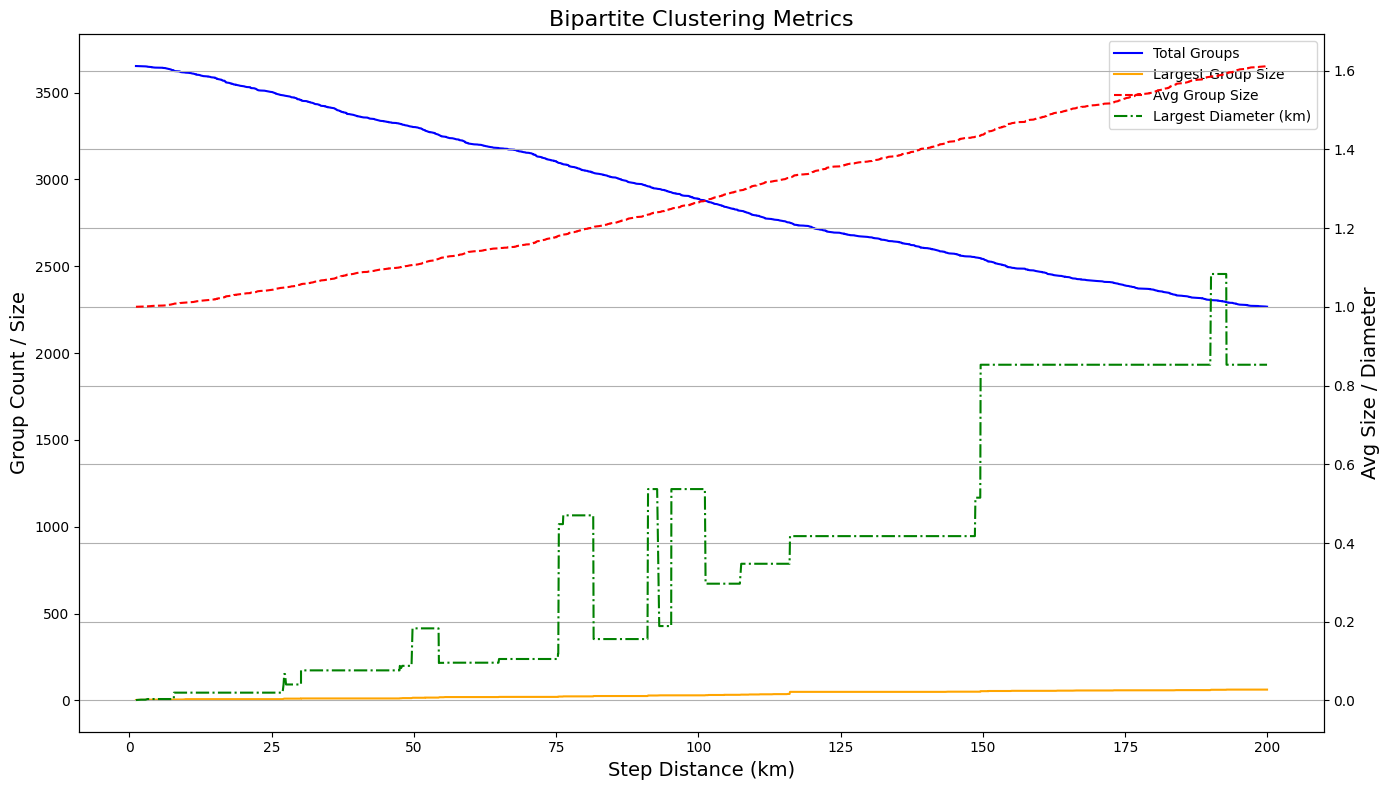

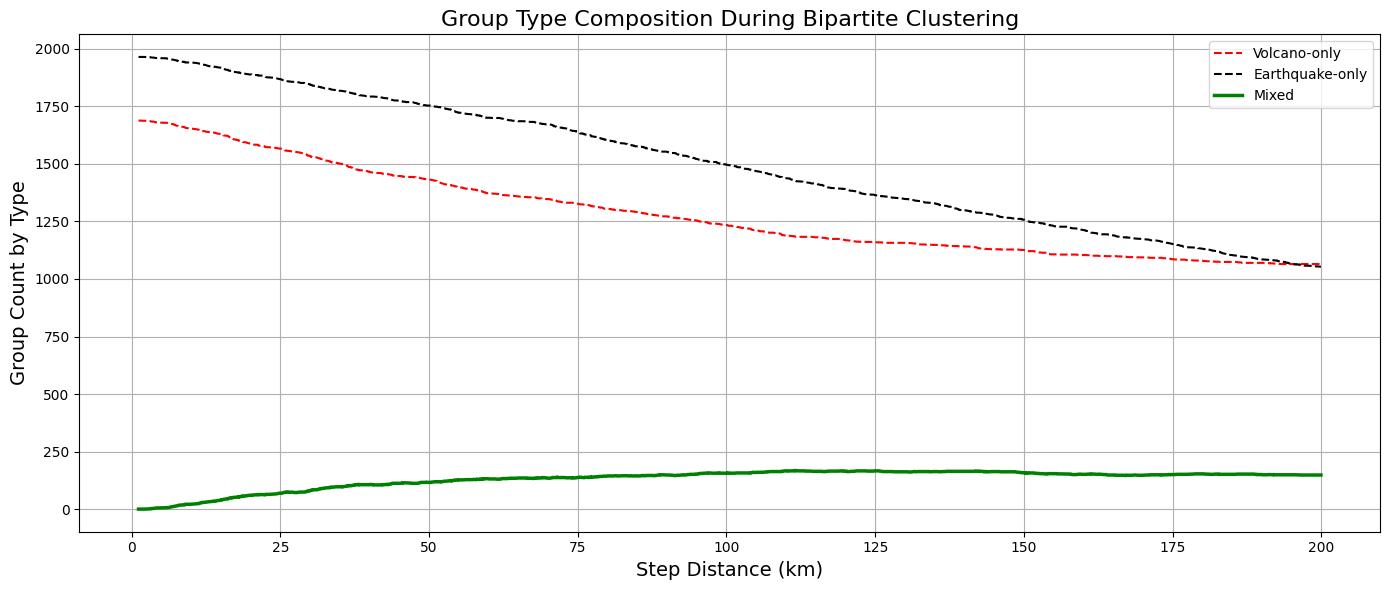

In [10]:
# === BIPARTITE CLUSTERING: VOLCANO–EARTHQUAKE GRAPH ===

import csv
import numpy as np
from geopy.distance import geodesic
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Load volcano and earthquake coordinates ---
def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

volcano_coords = []
earthquake_coords = []

with open("volcanoes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        volcano_coords.append(parse_coords(row['location']))

with open("earthquakes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        earthquake_coords.append(parse_coords(row['location']))

# --- PARAMETERS ---
MAX_DISTANCE_KM = 200  # discard volcano–earthquake pairs farther than this
K_NEAREST = 3  # for each earthquake, consider only k nearest volcanoes (to reduce number of pairs)
DIAMETER_SCALE = 1000  # scale factor for diameter when plotting (e.g., km to 1000 km)

# --- Build bipartite edge list with limited k nearest volcanoes for each earthquake ---
pairs = []
for ei, e_coord in enumerate(earthquake_coords):
    distances = []
    for vi, v_coord in enumerate(volcano_coords):
        dist = geodesic(e_coord, v_coord).km
        if dist <= MAX_DISTANCE_KM:
            distances.append((dist, vi, ei))
    distances.sort()
    pairs.extend(distances[:K_NEAREST])

pairs.sort()  # sort by increasing distance

# --- Clustering loop ---
volcano_count = len(volcano_coords)
earthquake_count = len(earthquake_coords)
total_points = volcano_count + earthquake_count

# Use disjoint-set (union-find) for cluster tracking
parent = list(range(total_points))

# Find the root of a node in the disjoint-set structure (with path compression)
def find(x):
    """Returns the representative/root of the set containing x."""
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x

# Union two sets in the disjoint-set structure
def union(x, y):
    """Merges the sets containing x and y."""
    xroot, yroot = find(x), find(y)
    if xroot != yroot:
        parent[yroot] = xroot

# --- Track metrics ---
step_distances = []
group_counts = []
avg_sizes = []
largest_sizes = []
largest_diameters = []
volcano_only = []
earthquake_only = []
mixed_groups = []

all_coords = volcano_coords + earthquake_coords

for step, (dist, vi, ei) in enumerate(pairs):
    vi_idx = vi  # volcano index
    ei_idx = volcano_count + ei  # earthquake index

    if find(vi_idx) != find(ei_idx):
        union(vi_idx, ei_idx)

        # Group by cluster
        clusters = defaultdict(list)
        for idx in range(total_points):
            clusters[find(idx)].append(idx)

        sizes = [len(c) for c in clusters.values()]
        avg_size = np.mean(sizes)
        largest_size = np.max(sizes)

        # Compute diameter for largest cluster
        largest_cluster = max(clusters.values(), key=len)
        coords = [all_coords[i] for i in largest_cluster]
        max_d = 0
        for i in range(len(coords)):
            for j in range(i+1, len(coords)):
                d = geodesic(coords[i], coords[j]).km
                if d > max_d:
                    max_d = d

        # Group type breakdown
        v_only = e_only = mixed = 0
        for cluster in clusters.values():
            types = {"volcano" if i < volcano_count else "earthquake" for i in cluster}
            if types == {"volcano"}:
                v_only += 1
            elif types == {"earthquake"}:
                e_only += 1
            else:
                mixed += 1

        # Store stats
        step_distances.append(dist)
        group_counts.append(len(clusters))
        avg_sizes.append(avg_size)
        largest_sizes.append(largest_size)
        largest_diameters.append(max_d)
        volcano_only.append(v_only)
        earthquake_only.append(e_only)
        mixed_groups.append(mixed)

        # Print progress
        if step % 100 == 0 or step == len(pairs) - 1:
            percent = step / len(pairs) * 100
            print(f"[{step:5d}/{len(pairs)}] — {percent:5.1f}% complete — dist = {dist:6.2f} km, clusters = {len(clusters):4d}, diameter = {max_d/DIAMETER_SCALE:.2f}")

# --- PLOT METRICS ---

fig, ax1 = plt.subplots(figsize=(14,8))
ax2 = ax1.twinx()

p1, = ax1.plot(step_distances, group_counts, label="Total Groups", color='blue')
p2, = ax1.plot(step_distances, largest_sizes, label="Largest Group Size", color='orange')
p3, = ax2.plot(step_distances, avg_sizes, label="Avg Group Size", color='red', linestyle='--')
p4, = ax2.plot(step_distances, [x/DIAMETER_SCALE for x in largest_diameters], label="Largest Diameter (km)", color='green', linestyle='-.')

ax1.set_xlabel("Step Distance (km)", fontsize=14)
ax1.set_ylabel("Group Count / Size", fontsize=14)
ax2.set_ylabel("Avg Size / Diameter", fontsize=14)

lines = [p1, p2, p3, p4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Bipartite Clustering Metrics", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SECOND PLOT: group type breakdown ---

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(step_distances, volcano_only, label="Volcano-only", color='red', linestyle='--')
ax.plot(step_distances, earthquake_only, label="Earthquake-only", color='black', linestyle='dashed')
ax.plot(step_distances, mixed_groups, label="Mixed", color='green', linewidth=2.5)

ax.set_xlabel("Step Distance (km)", fontsize=14)
ax.set_ylabel("Group Count by Type", fontsize=14)
ax.legend(loc='upper right')
plt.title("Group Type Composition During Bipartite Clustering", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()